<h2><center>Random Forest</center></h2>

In this section, we do a statistical modelling using random Forest. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

G:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Read the accident data from csv
df_traffic = pd.read_csv('data_wrangled.csv', 
                         index_col = 'Date Of Stop_Time Of Stop',
                         parse_dates = True,
                         infer_datetime_format = True)

df_traffic['V_sage'] = (df_traffic.V_Age - df_traffic.V_Age.min())/\
                  (df_traffic.V_Age.max() - df_traffic.V_Age.min())

not_relevant = ['Latitude', 'Longitude', 'Year', 'Description', 
                'Make', 'Model', 'Color', 'datetime', 'V_Age']
df_traffic.drop(labels = not_relevant, axis = 1,  inplace = True)

In [3]:
# Get X and y from data 
y = df_traffic['Violation Type_Warning']
df_X1 = df_traffic.drop('Violation Type_Warning', axis = 1)
X = df_X1.values

# now,  do a Logistic regression to the data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   test_size = 0.5, random_state=77)

In [5]:
# Setup the hyperparameter grid for a random forest gridsearch 
param_grid = {'max_features': np.arange(0.05,0.5, 0.05), 'n_estimators': np.arange(5,200,1), 
             'min_samples_leaf': np.arange(2, 100, 1), 
             'criterion': ['gini', 'entropy'], 'max_depth': np.arange(2, 100, 1), 
             'min_weight_fraction_leaf': np.arange(0,0.5, 0.05),
             'oob_score': [True, False], 'class_weight': ['balanced', 'balanced_subsample'], 
             'random_state':[77]}

# Instantiate a logistic regression classifier: Random Forest
model_rf = RandomForestClassifier()

# Instantiate the GridSearchCV object: logreg_cv
model_cv = RandomizedSearchCV(model_rf, param_grid, 
                              cv = 5, 
                              n_jobs = -1)

# Fit it to the data
model_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(model_cv.best_params_)) 
print("Best score is {}".format(model_cv.best_score_))

Tuned Random Forest Parameters: {'random_state': 77, 'oob_score': False, 'n_estimators': 137, 'min_weight_fraction_leaf': 0.0, 'min_samples_leaf': 80, 'max_features': 0.3, 'max_depth': 89, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best score is 0.7718160220406207


             precision    recall  f1-score   support

    Citaton       0.82      0.68      0.75    287164
    Warning       0.75      0.86      0.80    313908

avg / total       0.78      0.78      0.77    601072

AUC: 0.8634693970784391


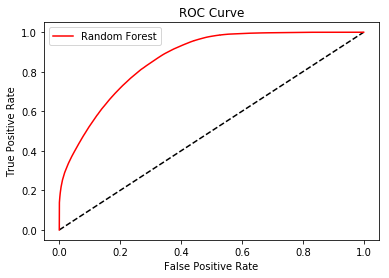

In [6]:
# Now it is turn of random forest
model_rf = RandomForestClassifier(n_estimators = 149, min_weight_fraction_leaf = 0.0, min_samples_leaf = 10,
                                  max_features = 0.2, max_depth = 45, criterion = 'gini', class_weight = 'balanced_subsample',
                                  oob_score = True,  n_jobs = -1, random_state = 77)
# Train the model using the training sets and check score
model_rf.fit(X_train, y_train)
#Predict Output
y_pred = model_rf.predict(X_test)

print(classification_report(y_test, y_pred,  target_names = ['Citaton', 'Warning']))


# Compute predicted probabilities: y_pred_prob
y_pred_prob = model_rf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr,tpr, thresholds = roc_curve(y_test, y_pred_prob)

print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 'r',label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [7]:
from joblib import dump, load
dump(model_rf, 'RANDOM_FOREST.joblib')

['RANDOM_FOREST.joblib']

G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


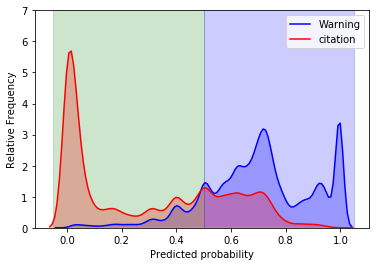

In [8]:
y_pred_prob = model_rf.predict_proba(X)[:,1]
ypp = pd.DataFrame(data = y_pred_prob, columns = ['predicted'])
ypp['real'] = y.values

ypp1 = ypp[ypp.real == 1]
ypp0 = ypp[ypp.real == 0]
ax = sns.kdeplot(ypp1.predicted, shade=True, color="b", label = 'Warning')
plt.fill_between([-0.05,0.5], 0, 10, color = 'g', alpha = 0.2)
plt.fill_between([0.5,1.05], 0, 10, color = 'b', alpha = 0.2)
plt.ylim(0, 7)
sns.kdeplot(ypp0.predicted, shade=True, color="r", ax = ax, label = 'citation')
plt.xlabel('Predicted probability')
plt.ylabel('Relative Frequency')
plt.show()